In [70]:
import pandas as pd
import numpy as np 
import os
import plotly.express as px
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from matplotlib import pyplot
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
import random

# For investigating timeseries data
from sklearn import preprocessing
from sklearn.model_selection import ParameterGrid
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose

# Modeling
from tqdm import tqdm_notebook
from itertools import product
import statsmodels.api as sm

### Loading Data

In [71]:
# Reading Data
base_path =  os.getcwd()
file_name = 'Traffic_Data.xlsx'
total_path = base_path + '//Data//' 
df = pd.read_excel(total_path + file_name, sheet_name='Sheet1')

# Filtering for just one state
df = df[df['State'] == 'Washington']
df = df.sort_values(by = ['Date'])
df.head(10)

,State,Region,STATIONS,CMILES,PMILES,Month,Month_2,Year,Date
3058,Washington,West,130,4586,4383,January,1,2019,2019-01-01
3007,Washington,West,158,4089,4474,February,2,2019,2019-02-01
2956,Washington,West,166,5245,5233,March,3,2019,2019-03-01
2905,Washington,West,170,5404,5229,April,4,2019,2019-04-01
2854,Washington,West,169,6041,5844,May,5,2019,2019-05-01
2803,Washington,West,163,5881,5758,June,6,2019,2019-06-01
2752,Washington,West,163,5816,5742,July,7,2019,2019-07-01
2701,Washington,West,125,5626,5516,August,8,2019,2019-08-01
2650,Washington,West,158,5721,5660,September,9,2019,2019-09-01
2599,Washington,West,161,5241,5189,October,10,2019,2019-10-01


### Plotting Data

In [72]:
fig = px.scatter(df, x="Date", y="CMILES", title = 'Miles Driven by Time')
fig.show()

### Seasonal Decomposition

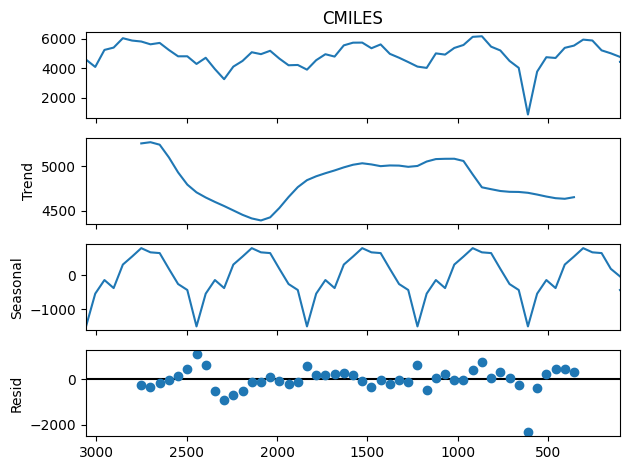

In [73]:
result = seasonal_decompose(df['CMILES'], model='additive', period=12)
result.plot()
pyplot.show()

### Splitting Into Test/Train

In [74]:
test_train_split = 0.8
pre_split = df[['CMILES', 'Date']].copy()
pre_split = pre_split.rename(columns= {'CMILES':'y',
                                       'Date':'ds'})
train = pre_split[:int(test_train_split * len(pre_split['y']))]
test = pre_split[int(test_train_split * len(pre_split['y'])):]
print('Total Length: ', len(pre_split))
print('Train Length: ', len(train))
print('Test Length: ', len(test))
test.head(10)


Total Length:  60
Train Length:  48
Test Length:  12


,y,ds
610,858,2023-01-01
559,3772,2023-02-01
508,4750,2023-03-01
457,4698,2023-04-01
406,5387,2023-05-01
355,5537,2023-06-01
304,5945,2023-07-01
253,5885,2023-08-01
202,5216,2023-09-01
151,5015,2023-10-01


### Fitting Prophet Model

In [75]:
model = Prophet()
model.fit(train)

12:05:17 - cmdstanpy - INFO - Chain [1] start processing
12:05:18 - cmdstanpy - INFO - Chain [1] done processing


### Forecasting

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Timeseries-Forecasting\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Timeseries-Forecasting\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



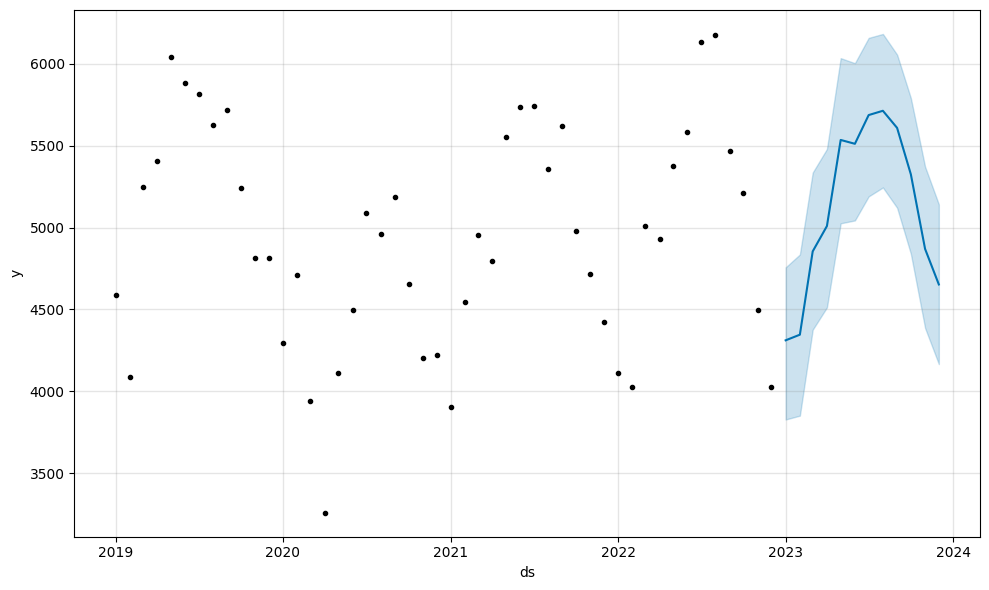

In [76]:
forecast = model.predict(test)
fig1 = model.plot(forecast)

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Timeseries-Forecasting\.venv\Lib\site-packages\prophet\plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Timeseries-Forecasting\.venv\Lib\site-packages\prophet\plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\seelc\OneDrive\Desktop\Lucas Desktop Items\Projects\Timeseries-Forecasting\.venv\Lib\site-packages\prophet\plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series c

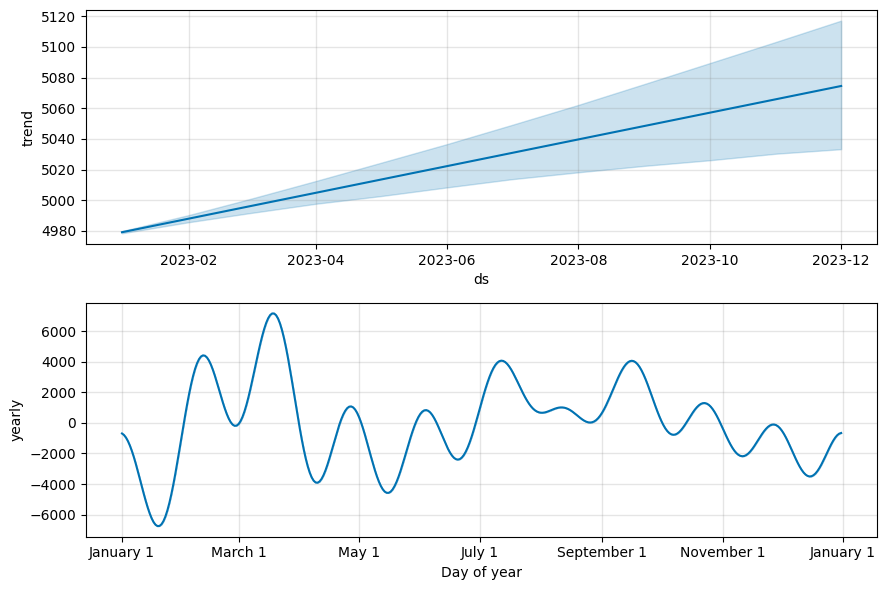

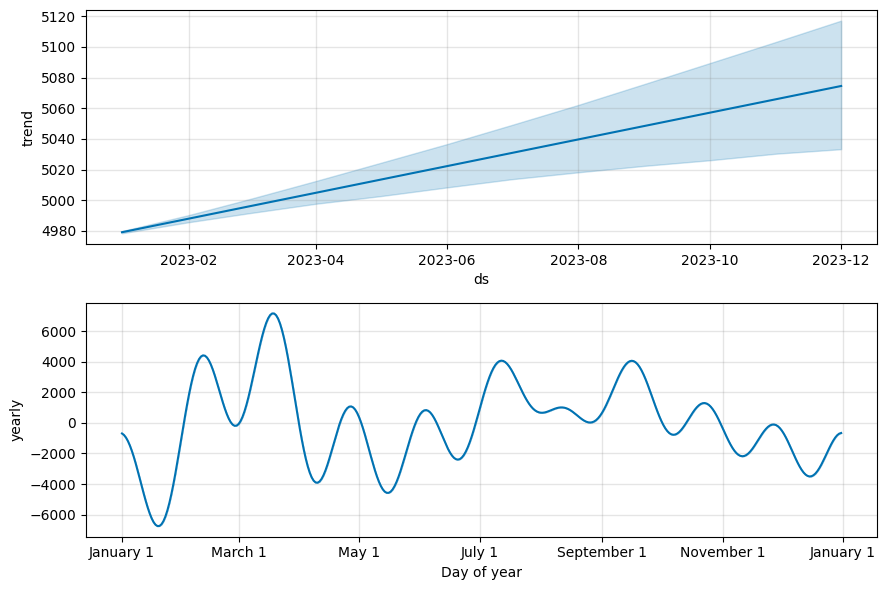

In [77]:
# Generation seasonal decomposition
model.plot_components(forecast)

In [78]:
# Want to Assess module performance
y_true = test['y'].values
y_pred = forecast['yhat'].values
mape = mean_absolute_percentage_error(y_true, y_pred)
print('MAE: ', mape)

MAE:  0.3858606779440302


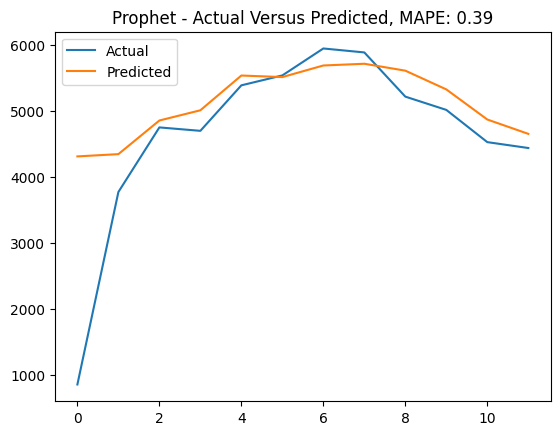

In [79]:
pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.title("Prophet - Actual Versus Predicted, MAPE: "+ str(round(mape,2)))
pyplot.legend()
pyplot.show()

### Hyperparameter Tuning of Prophet Model

In [80]:
# Defining Parameter grid to perform hyperparameter tuning over
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.3,0.5],
              'n_changepoints' : [100,200]}
grid = ParameterGrid(params_grid)

In [85]:
random.seed(42)
model_parameters = {}
for parameters in grid:
    train_model = Prophet(changepoint_prior_scale = parameters['changepoint_prior_scale'],
                         n_changepoints = parameters['n_changepoints'],
                         seasonality_mode = parameters['seasonality_mode'],
                         yearly_seasonality = True, 
                         interval_width=0.8)
    train_model.fit(train)
    
    forecast = train_model.predict(test)
    y_true = test['y'].values
    y_pred = forecast['yhat'].values
    mape = mean_absolute_percentage_error(y_true, y_pred)
    # Adding mape + parameters to dataframe to compare models performance
    print('MAPE: ', mape, ' Parameters: ', parameters)
    model_parameters[str(parameters)] = mape


12:08:45 - cmdstanpy - INFO - Chain [1] start processing
12:08:45 - cmdstanpy - INFO - Chain [1] done processing
12:08:46 - cmdstanpy - INFO - Chain [1] start processing


MAPE:  0.41688775590738336  Parameters:  {'changepoint_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


12:08:46 - cmdstanpy - INFO - Chain [1] done processing
12:08:46 - cmdstanpy - INFO - Chain [1] start processing


MAPE:  0.41659876862392564  Parameters:  {'changepoint_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


12:08:47 - cmdstanpy - INFO - Chain [1] done processing
12:08:47 - cmdstanpy - INFO - Chain [1] start processing


MAPE:  0.41688775590738336  Parameters:  {'changepoint_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


12:08:48 - cmdstanpy - INFO - Chain [1] done processing
12:08:48 - cmdstanpy - INFO - Chain [1] start processing


MAPE:  0.41659876862392564  Parameters:  {'changepoint_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


12:08:48 - cmdstanpy - INFO - Chain [1] done processing
12:08:49 - cmdstanpy - INFO - Chain [1] start processing


MAPE:  0.37082343595075445  Parameters:  {'changepoint_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


12:08:49 - cmdstanpy - INFO - Chain [1] done processing
12:08:50 - cmdstanpy - INFO - Chain [1] start processing


MAPE:  0.3649680565930606  Parameters:  {'changepoint_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


12:08:50 - cmdstanpy - INFO - Chain [1] done processing
12:08:50 - cmdstanpy - INFO - Chain [1] start processing


MAPE:  0.37082343595075445  Parameters:  {'changepoint_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


12:08:51 - cmdstanpy - INFO - Chain [1] done processing
12:08:51 - cmdstanpy - INFO - Chain [1] start processing


MAPE:  0.3649680565930606  Parameters:  {'changepoint_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


12:08:52 - cmdstanpy - INFO - Chain [1] done processing
12:08:52 - cmdstanpy - INFO - Chain [1] start processing


MAPE:  0.3644242446363936  Parameters:  {'changepoint_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


12:08:53 - cmdstanpy - INFO - Chain [1] done processing
12:08:53 - cmdstanpy - INFO - Chain [1] start processing


MAPE:  0.3611214085097087  Parameters:  {'changepoint_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


12:08:53 - cmdstanpy - INFO - Chain [1] done processing
12:08:54 - cmdstanpy - INFO - Chain [1] start processing


MAPE:  0.3644242446363936  Parameters:  {'changepoint_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


12:08:54 - cmdstanpy - INFO - Chain [1] done processing


MAPE:  0.3611214085097087  Parameters:  {'changepoint_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


In [92]:
model_parameters_df = pd.DataFrame.from_dict(model_parameters, 
                                             columns = ['Mape'], orient='index')
model_parameters_df = model_parameters_df.reset_index()
model_parameters_df = model_parameters_df.rename(columns={'index':'Parameters'})
model_parameters_df = model_parameters_df.sort_values(by = ['Mape'])
model_parameters_df.head(10)

,Parameters,Mape
9,"{'changepoint_prior_scale': 0.5, 'n_changepoin...",0.361121
11,"{'changepoint_prior_scale': 0.5, 'n_changepoin...",0.361121
8,"{'changepoint_prior_scale': 0.5, 'n_changepoin...",0.364424
10,"{'changepoint_prior_scale': 0.5, 'n_changepoin...",0.364424
5,"{'changepoint_prior_scale': 0.3, 'n_changepoin...",0.364968
7,"{'changepoint_prior_scale': 0.3, 'n_changepoin...",0.364968
4,"{'changepoint_prior_scale': 0.3, 'n_changepoin...",0.370823
6,"{'changepoint_prior_scale': 0.3, 'n_changepoin...",0.370823
1,"{'changepoint_prior_scale': 0.1, 'n_changepoin...",0.416599
3,"{'changepoint_prior_scale': 0.1, 'n_changepoin...",0.416599
